In [1]:
import numpy as np
from qiskit.providers.aer import  QasmSimulator
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram

from qiskit.aqua.algorithms import DeutschJozsa

In [2]:
def generate_oracle(mode, inputs):
    oracle = QuantumCircuit(inputs+1)

    if mode == 'balanced':
        random_number = bin(np.random.randint(1,2**inputs)).strip('0b')

        for i, qbit in enumerate(random_number):
            if qbit == '1':
                oracle.x(i)

        oracle.cx(range(inputs),inputs)

        for i, qbit in enumerate(random_number):
            if qbit == '1':
                oracle.x(i)
    elif mode == 'constant':
        output = np.random.randint(2)
        if output == 1:
            oracle.z(inputs)

    oracle_gate = oracle.to_gate()
    oracle_gate.name = 'Oracle'
    return oracle_gate

def dj_algorithm(oracle, inputs):
    dj_circuit = QuantumCircuit(inputs + 1,inputs)

    dj_circuit.x(inputs)
    dj_circuit.h(inputs)

    dj_circuit.h(range(inputs))

    dj_circuit.barrier()
    dj_circuit.append(oracle, range(inputs+1))
    dj_circuit.barrier()

    dj_circuit.h(range(inputs))

    dj_circuit.barrier()
    dj_circuit.measure(range(inputs), range(inputs))

    return dj_circuit

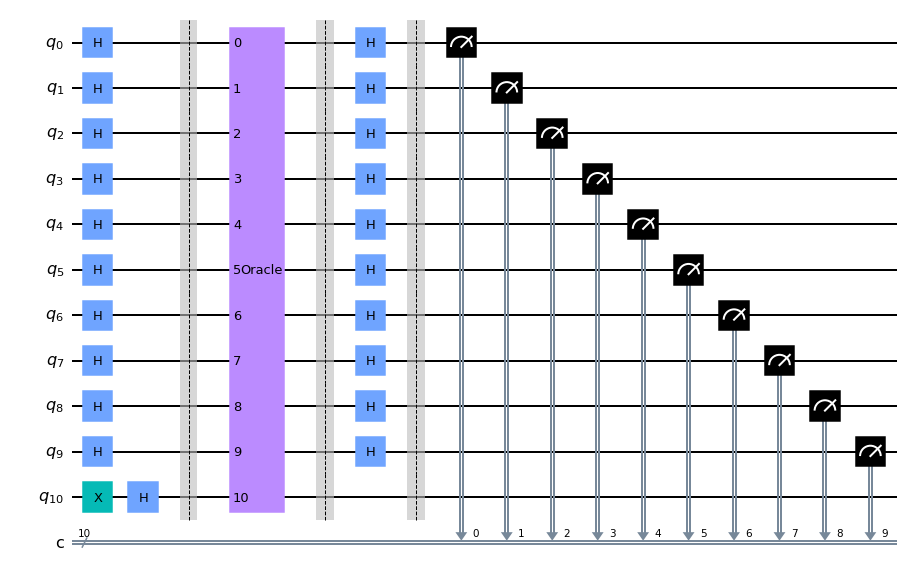

In [3]:
IBMQ.load_account()
n = 4
oracle = generate_oracle('constant', n)
dj_circuit = dj_algorithm(oracle, n)
dj_circuit.draw('mpl')

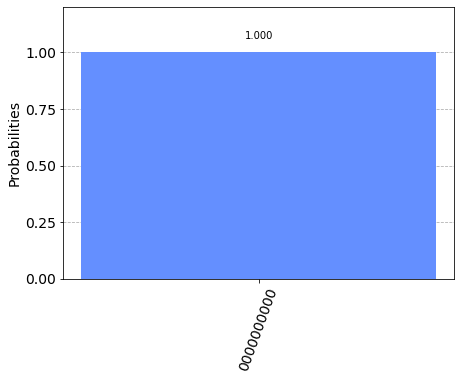

In [4]:
qasm_sim = QasmSimulator()
qobj = assemble(transpile(dj_circuit, qasm_sim))
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [5]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and not x.configuration().simulator and x.status().operational==True))

print('least busy', backend)

least busy ibmq_16_melbourne


In [6]:
from qiskit.tools.monitor import job_monitor

transpiled_circuit = transpile(dj_circuit, backend, optimization_level=3)
# qobj = assemble(transpiled_circuit,backend)
job = backend.run(transpiled_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


{'0000000000': 417, '0000000001': 79, '0000010000': 38, '0100000000': 44, '0100000001': 6, '0100000010': 10, '0100000100': 3, '0100000101': 1, '0100001000': 1, '0100001010': 1, '0000010001': 7, '0100010000': 7, '0100010010': 2, '0000010010': 9, '0100100000': 4, '0100100010': 1, '0100100101': 1, '0000010011': 1, '0100110000': 1, '0100110001': 1, '0000010100': 4, '0101000001': 1, '0000010101': 1, '0000010110': 1, '0101100000': 2, '0000011000': 2, '0110000000': 1, '0110000100': 1, '0110100001': 1, '0110100011': 1, '0111000000': 1, '0000000010': 75, '0000100000': 65, '1000000000': 3, '1000000001': 1, '1000000100': 1, '1000001000': 1, '0000100001': 7, '0000100010': 9, '1000100000': 4, '1000100001': 1, '0000100011': 2, '0000100100': 6, '0000100110': 1, '0000101000': 2, '0000101001': 1, '0000101010': 2, '0000000011': 10, '0000110000': 3, '1100000000': 1, '0000110010': 2, '0000110101': 1, '0000110110': 1, '0000000100': 33, '0001000000': 46, '0001000001': 4, '0001000010': 8, '0001000011': 2, '0

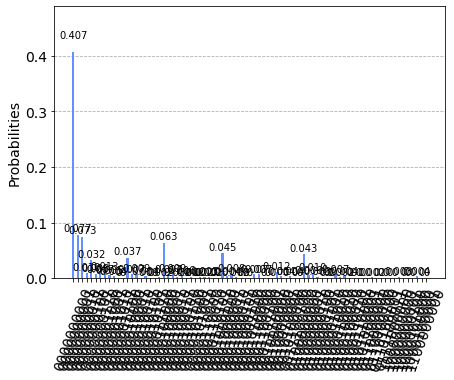

In [7]:
results = job.result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)
